##Build model by using Torch.nn


### Get MNIST data

In [ ]:
from pathlib import Path
import requests
import pickle
import gzip

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")


parents플래그가True인 경우 상위 디렉토리를 포함하여 경로의 누락 된 디렉토리를 작성. path.mkdir은parents플래그가False인 경우 상위 디렉토리가 누락 된 경우FileNotFoundError를 리턴하지만 여전히 중간 디렉토리를 작성함. exist_OK는 기본적으로 False이며 지정된 디렉토리가 이미 존재하는 경우FileExistsError가 발생. exist_OK가 True이면 FileExistsError를 무시

(50000, 784)


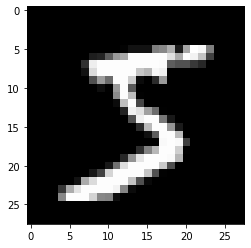

In [ ]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [ ]:
# 파이토치 사용을 위해 데이터를 텐서로 바꿔줌
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


### 1. torch.nn 없이 신경망 구현

In [ ]:
import math

weights = torch.randn(784, 10) / math.sqrt(784) # 가중치 초기화 Xavier initialisation
print(weights.shape)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

torch.Size([784, 10])


가중치 초깃값에 대해서는 아래 링크를 참고

https://velog.io/@cha-suyeon/DL-%EA%B0%80%EC%A4%91%EC%B9%98-%EC%B4%88%EA%B8%B0%ED%99%94Weight-Initialization-

In [ ]:
# 활성화 함수
def log_softmax(x):
  return x - x.exp().sum(-1).log().unsqueeze(-1)

# 모델
def model(xb):
  return log_softmax(xb @ weights + bias)

In [ ]:
bs = 64 # 배치 사이즈

xb = x_train[0:bs] # train data에서 미니 배치 추출
preds = model(xb) # 추측한 값
print(preds[0], preds.shape)

tensor([-2.0826, -2.4304, -2.2668, -2.5839, -2.6643, -2.5081, -2.9126, -1.9124,
        -2.0127, -2.1078], grad_fn=<SelectBackward0>) torch.Size([64, 10])


In [ ]:
# loss function - 로그 우도
# inpute은 preds, target은 실제 label (yb값)
def logLikelihood(input, target):
  return -input[range(target.shape[0]), target].mean()

loss_func = logLikelihood

In [ ]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3599, grad_fn=<NegBackward0>)


In [ ]:
def accuracy(out, yb):
  preds = torch.argmax(out, dim=1) # dim = 1 행을 기준으로 max
  return (preds == yb).float().mean()

print(accuracy(preds, yb))

tensor(0.1406)


In [ ]:
lr = 0.5
epochs = 2

for epoch in range(epochs):
  for i in range((n-1) // bs + 1): # n = 50000, train data 수
    start_i = i * bs
    end_i = start_i + bs
    xb = x_train[start_i : end_i]
    yb = y_train[start_i : end_i]
    pred = model(xb)
    loss = loss_func(pred, yb)

    loss.backward()
    with torch.no_grad(): # weights와 bias 갱신에서는 gradient 계산 불필요
      weights -= weights.grad * lr
      bias -= bias.grad * lr
      weights.grad.zero_()
      bias.grad.zero_()

In [ ]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0797, grad_fn=<NegBackward0>) tensor(1.)


###Using torch.nn.functional

In [ ]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb): # 활성화 함수 호출 생략 가능
  return xb @ weights + bias

In [ ]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0797, grad_fn=<NllLossBackward0>) tensor(1.)


###Refactor using nn.Module

In [ ]:
from torch import nn

class Mnist_Logistic(nn.Module): # nn.Module을 상속받아 모델 클래스 구현
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
    self.bias = nn.Parameter(torch.zeros(10))

  def forward(self, xb):
    return xb @ self.weights + self.bias

In [ ]:
model = Mnist_Logistic()

In [ ]:
print(loss_func(model(xb), yb))

tensor(2.2776, grad_fn=<NllLossBackward0>)


In [ ]:
def fit():
  for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
      start_i = i * bs
      end_i = start_i + bs
      xb = x_train[start_i : end_i]
      yb = y_train[start_i : end_i]
      pred = model(xb)
      loss = loss_func(pred, yb)

      loss.backward()
      with torch.no_grad(): # weights와 bias 갱신에서는 gradient 계산 불필요
        for p in model.parameters():
          p -= p.grad * lr
        model.zero_grad()
fit()

In [ ]:
print(loss_func(model(xb), yb))

tensor(0.0812, grad_fn=<NllLossBackward0>)


###Using nn.Linear

In [ ]:
class Mnist_Logistic(nn.Module):
  def __init__(self):
    super().__init__()
    self.lin = nn.Linear(784, 10)

  def forward(self, xb):
    return self.lin(xb)

In [ ]:
model = Mnist_Logistic()

In [ ]:
print(loss_func(model(xb), yb))
fit()
print(loss_func(model(xb), yb))

tensor(2.2322, grad_fn=<NllLossBackward0>)
tensor(0.0815, grad_fn=<NllLossBackward0>)


###Using Optim

In [ ]:
"""
아래 코드를 대체해줄 optim
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad() 

opt.step()
opt.zero_grad()
"""

'\n아래 코드를 대체해줄 optim\nwith torch.no_grad():\n    for p in model.parameters(): p -= p.grad * lr\n    model.zero_grad() \n\nopt.step()\nopt.zero_grad()\n'

In [ ]:
from torch import optim

def get_model():
  model = Mnist_Logistic()
  return model, optim.SGD(model.parameters(), lr=lr) # 최적화 할 매개변수와 학습률

model, opt = get_model()
print(loss_func(model(xb), yb))

tensor(2.3294, grad_fn=<NllLossBackward0>)


In [ ]:
for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0836, grad_fn=<NllLossBackward0>)


###Refactor using Dataset

In [ ]:
from torch.utils.data import TensorDataset

"""
  이전까지는 
  xb = x_train[start_i:end_i]
  yb = y_train[start_i:end_i]
  feature와 label을 따로 관리
"""
train_ds = TensorDataset(x_train, y_train)
xb, yb = train_ds[i*bs : i*bs+bs]

model, opt = get_model()

for epoch in range(epochs):
  for i in range((n-1) // bs + 1):
    xb, yb = train_ds[i*bs : i*bs+bs]
    pred = model(xb)
    loss = loss_func(pred, yb)

    loss.backward()
    opt.step()
    opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0818, grad_fn=<NllLossBackward0>)


###Refactor using Dataloader

utils.data의 dataset은 데이터 셋의 feature를 가져오고 하나의 샘플에 label을 지정함. 모델을 학습할 때 보통 미니배치로 전달하고 매 epoch마다 데이터를 다시 섞어 overfit을 방지함.
> dataloader는 이 과정을 간단히 추상화한 순회 가능한 객체임

In [ ]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs) # dataloader : iterable

In [ ]:
# data를 loading 하는 반복문이 간결해짐
for xb, yb in train_dl:
  pred = model(xb)

In [ ]:
model, opt = get_model()

for epoch in range(epochs):
  for xb, yb in train_dl:
    pred = model(xb)
    loss = loss_func(pred, yb)

    loss.backward()
    opt.step()
    opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0813, grad_fn=<NllLossBackward0>)


###Add validation

In [ ]:
# 학습 데이터로 훈련시킨 모델을 테스트 데이터로 검증
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size = bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2) # 역전파 과정이 필요 없으므로 더 큰 배치 크기로 빠른 연산

In [ ]:
model, opt = get_model()

for epoch in range(epochs):
  for xb, yb in train_dl:
    pred = model(xb)
    loss = loss_func(pred, yb)

    loss.backward()
    opt.step()
    opt.zero_grad()
  model.eval()
  with torch.no_grad():
    valid_loss = sum(loss_func(model(xb), yb) for xb, yb, in valid_dl)
  print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3172)
1 tensor(0.2865)


###Refactoring

In [ ]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [ ]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

In [ ]:
def get_data(train_ds, valid_ds, bs):
  return (DataLoader(train_ds, batch_size=bs, shuffle=True), DataLoader(valid_ds, batch_size=bs*2))

In [ ]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.29944288229942323
1 0.30238742661476137
